# Bachelier 

# General Imports and Settings

In [ ]:
!pip install jaxtyping
!pip install equinox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for jax: filename=jax-0.4.11-py3-none-any.whl size=1487877 sha256=a474de0ae8a61316fcca35e8c13381ea18fa2fa2ac2cc259a6c8c941427c374a
  Stored in directory: /root/.cache/pip/wheels/24/d2/da/9e8cec7afad3784f022c4dd1184ba33f9220a9d24b712e50eb
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.4.10
    Uninstalling jax-0.4.10:
      Successfully uninstalled jax-0.4.10


In [ ]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from typing import Sequence
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

jax.devices()

jax.enable_checks = True

In [ ]:
# list requirements
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

jax==0.4.11
equinox==0.10.5
optax==0.1.5
chex==0.1.7
tensorflow==2.12.0
tensorflow_datasets==4.9.2
numpy==1.22.4


In [ ]:
# test: edited with colab
NUM_EPOCHS = 100
BATCH_SIZE = 256
BUFFER_SIZE = 1024
STEPS_PER_EPOCH = 100
LEARNING_RATE = 0.01
N_TRAINING_SAMPLES = 8 * 1024
N_TEST_SAMPLES = 4096
SEED = 42

In [ ]:
@eqx.filter_jit
def value_and_jacrev(f, x):
    # Function that computes both the values and the Jacobian using reverse mode autodiff
    y, vjpfun = jax.vjp(f, x)  # Compute the values and obtain a VJP function
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    return y, jac, vjpfun

@eqx.filter_jit
def value_and_jacobian(f, x):
    y, jac, _ = value_and_jacrev(f, x)
    return y, jac

# Bachelier Dataset

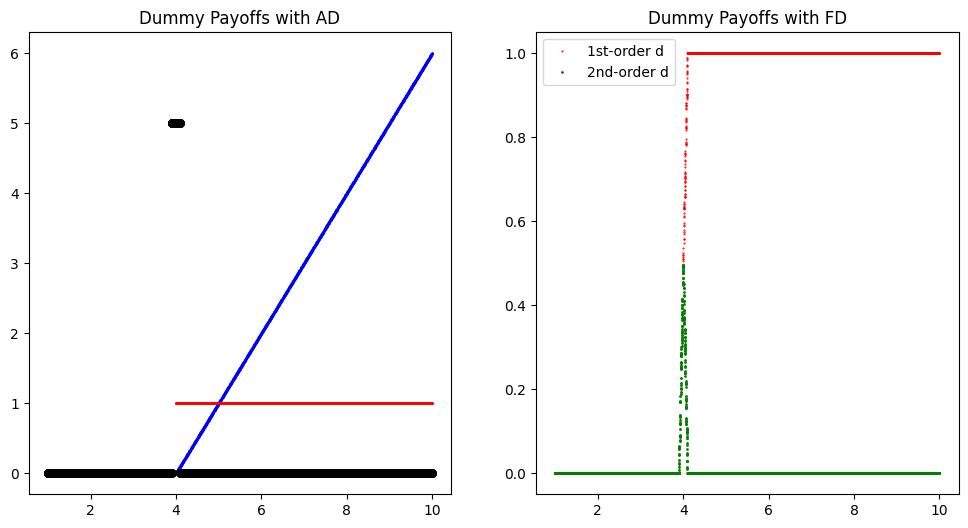

In [ ]:
# plt.style.use('seaborn-poster')

def dummy_payoff(xs, K=4):
  return jnp.maximum(0, xs - K)

seed = 42
n = N_TRAINING_SAMPLES
key = random.PRNGKey(seed)
key, subkey = random.split(key)
xs = random.uniform(subkey, shape=(n,), minval=1.0, maxval=10.0)
ys = dummy_payoff(xs)

dpayoff = grad(dummy_payoff)
dys = vmap(dpayoff)(xs)
ddys = vmap(grad(dpayoff))(xs)

h = 0.1
fd_xph = vmap(dpayoff)(xs + h)
fd_xmh = vmap(dpayoff)(xs - h)
ddys_fd = (fd_xph - fd_xmh) / (2 * h)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axs[0].set_title("Dummy Payoffs with AD")
axs[0].plot(xs, ys, 'b.', markersize=1, label='values')
axs[0].plot(xs, dys, 'r.', markersize=1, label='1st-order d')
axs[0].plot(xs, ddys, 'g--', markersize=1, label='2nd-order d')
axs[0].plot(xs, ddys_fd, 'k.', markersize=10, label='2nd-order fd d')
# axs[0].legend()

h = 0.1
fd_xph = dummy_payoff(xs + h)
fd_xmh = dummy_payoff(xs - h)
fd = (fd_xph - fd_xmh) / (2 * h)
fdd = (fd_xph - 2 * ys + fd_xmh) / (2 * h)

# fd_over_fd = (fd_xph - fd_xmh) / (2 * h)

# hs = jnp.diag(jnp.ones_like(xs) * h)
# fd_xph = xs + hs
# fd_xmh = xs - hs
# fd_ = (fd_xph - fd_xmh) / (2 * h)
# fd = jnp.diag(fd_)
# print(xs)
# print(xs + hs)
# print(fd.shape)

# Second plot
axs[1].set_title("Dummy Payoffs with FD")
# axs[1].plot(xs, ys, 'b.', markersize=1, label='values')
# axs[1].plot(xs[:-1], fd, 'b.', markersize=1, label='1st-order d')
axs[1].plot(xs, fd, 'r.', markersize=1, label='1st-order d')
axs[1].plot(xs, fdd, 'g.', markersize=2, label='2nd-order d')
axs[1].legend()

plt.show()

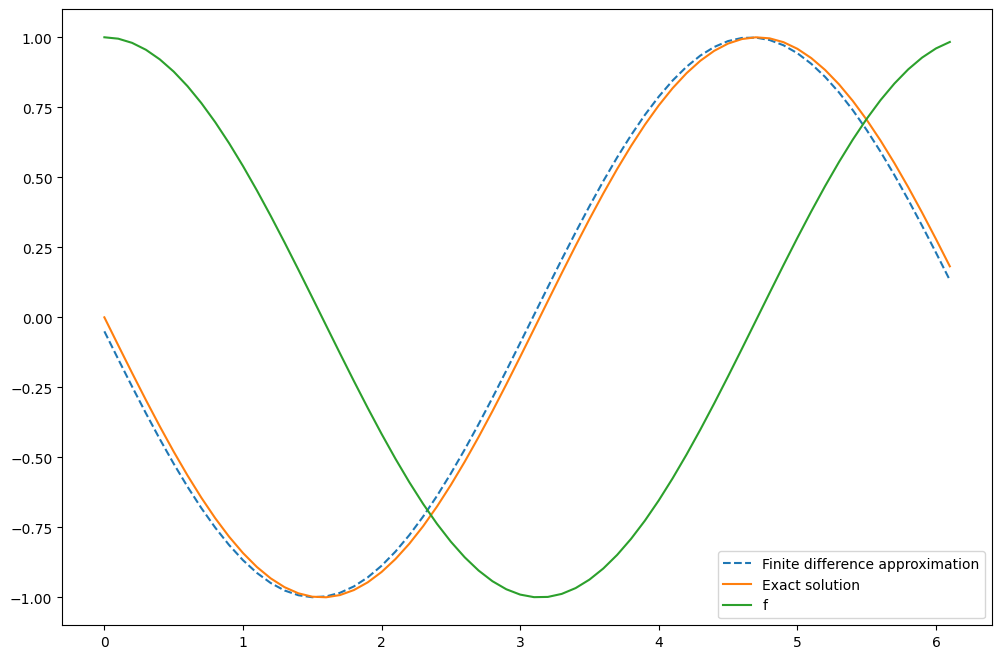

0.04998418


In [ ]:
# step size
h = 0.1
# define grid
x = jnp.arange(0, 2*jnp.pi, h) 
# compute function
y = jnp.cos(x) 

# compute vector of forward differences
forward_diff = jnp.diff(y)/h 
# compute corresponding grid
x_diff = x[:-1:] 
# compute exact solution
exact_solution = -jnp.sin(x_diff) 

# Plot solution
plt.figure(figsize = (12, 8))
plt.plot(x_diff, forward_diff, '--', \
         label = 'Finite difference approximation')
plt.plot(x_diff, exact_solution, \
         label = 'Exact solution')
plt.plot(x_diff, jnp.cos(x_diff), label = 'f')
plt.legend()
plt.show()

# Compute max error between 
# numerical derivative and exact solution
max_error = max(abs(exact_solution - forward_diff))
print(max_error)


In [ ]:
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)
    
# generates a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])


@dataclass(eq=True, frozen=True)
class BachelierParams:
    n_dim: int = 1
    T1: float = 1.0
    T2: float = 2.0
    K: float = 1.10
    test_set_lb = 0.5
    test_set_ub = 1.50
    volMult: float = 1.5
    bktVol: float = 0.2
    anti: bool = True

class TrainingSet(eqx.Module):
    X: Array 
    Y: Array
    Z: Array
    W: Array
    weights: Array
    inc1: Array
    Z_fd: Array
    W_fd_of_fd: Array
    W_fd_of_vjp: Array
    W_fd_of_grad: Array

    def shapes(self):
        jax.debug.print("X {X}, Y {Y}, Z {Z}, W {W}", X=X.shape, Y=Y.shape, Z=Z.shape, W=W.shape)
        

def payoff_fn(X, inc1, a, K):
    S2 = X + inc1
    bkt2 = jnp.dot(S2, a)
    pay = jnp.maximum(0, bkt2 - K)

    # two antithetic paths
    # if anti:
    if False:
        
        S2a = X - inc1
        bkt2a = jnp.dot(S2a, a)
        paya = jnp.maximum(0, bkt2a - K)
        
        Y = 0.5 * (pay + paya)
    # standard
    else:
        Y = pay

    return Y

           
# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3))
def trainingSet(m: int, params: BachelierParams, seed=2, bktVol=0.2):
    n = params.n_dim
    T1 = params.T1
    T2 = params.T2
    K = params.K
    volMult = params.volMult
    anti = params.anti

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)

    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    vols = vols * bktVol / v
    jax.debug.print("vols is= {v}", v=vols)
    bktVol = bktVol
    jax.debug.print("bkt vol is= {v}", v=bktVol)

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))
    inc0 = normals[0, :, :] @ chol0.T
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

    def analytic_grad(X, inc1):
        S2 = X + inc1
        bkt2 = jnp.dot(S2, a)
        pay = jnp.maximum(0, bkt2 - K)

        # two antithetic paths
        # if anti:
        if False:
            S2a = X - inc1
            bkt2a = jnp.dot(S2a, a)
            paya = jnp.maximum(0, bkt2a - K)
            
            # differentials
            Z1 =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
            Z2 =  jnp.where(bkt2a > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
            Z_analytic = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
            # differentials
            Z_analytic = jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        return Z_analytic
      
    payoff = partial(payoff_fn, a=a, K=K)

    Z_analytic = analytic_grad(S1, inc1)
    # Compute the values and obtain a VJP function
    Y_vjp, vjpfun = jax.vjp(payoff, S1, inc1)
    Z_vjp = vjpfun(jnp.ones(Y_vjp.size))[0]
    # if not independent, we need to use the commented out section instead
    # basis = jnp.eye(y.size, dtype=y.dtype)
    # Z_vjp = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function

    h = 1e-4
    fd_ph = payoff(S1 + h, inc1)
    fd_mh = payoff(S1 - h, inc1)
    Z_fd = (fd_ph - fd_mh) / (2 * h)

    # using second order finite differences
    h = 1e-2
    fdd = (fd_ph - 2 * Y_vjp + fd_mh) / (h * h)
    W_fd_of_fd = fdd[..., jnp.newaxis]

    # using first order finite difference over vjp
    h = 1e-4
    fd_of_vjp_ph = vjpfun(jnp.ones(Y_vjp.size) + h)[0]
    fd_of_vjp_mh  = vjpfun(jnp.ones(Y_vjp.size) - h)[0]
    W_fd_of_vjp = (fd_of_vjp_ph - fd_of_vjp_mh) / (2 * h)

    Dpayoff = vmap(jax.grad(payoff))
    W_fd_of_grad_ph = Dpayoff(S1 + h, inc1)
    W_fd_of_grad_mh = Dpayoff(S1 - h, inc1)
    W_fd_of_grad = (W_fd_of_grad_ph - W_fd_of_grad_mh) / (2 * h)

    Y, Z_grad = jax.vmap(jax.value_and_grad(payoff, argnums=0))(S1, inc1)

    jax.debug.print("W_fd_of_fd vs W_fd_of_vjp {mse}", mse=jnp.mean(jnp.square(W_fd_of_fd - W_fd_of_vjp)))
    jax.debug.print("Example values: {val1}, {val2}", val1=Z_grad[2,0], val2=Z_vjp[2,0])
    jax.debug.print("MSE(Z_grad, Z_analytic) = {res}", res=jnp.mean((Z_grad - Z_analytic)**2))
    jax.debug.print("MSE(Z_vjp, Z_analytic) = {res}", res=jnp.mean((Z_vjp - Z_analytic)**2))
    jax.debug.print("MSE(Y_vjp, Y) = {res}", res=jnp.mean((Y_vjp - Y)**2))
    jax.debug.print("Close(Y_vjp, Y) ? {res}", res=jnp.allclose(Y_vjp, Y))
    jax.debug.print("Close(Z_vjp, Z) ? {res}", res=jnp.allclose(Z_vjp, Z_analytic))
    jax.debug.print("Close(Z_grad, Z) ? {res}", res=jnp.allclose(Z_grad, Z_analytic))

    W_hessian = jax.vmap(jax.hessian(payoff, argnums=0))(S1, inc1)
    
    X = S1
    return TrainingSet(X, Y_vjp.reshape(-1,1), Z_vjp, W_hessian, a, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad)

def testSet(params: BachelierParams, training_set: TrainingSet, n_samples:int=4096, seed:int=42):
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas

    n = params.n_dim
    K = params.K
    bktVol = params.bktVol
    T1 = params.T1
    T2 = params.T2
    lower = params.test_set_lb
    upper = params.test_set_ub
    weights = training_set.weights
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(n_samples, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, weights).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ weights.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1) 
    return spots, baskets, prices, deltas, vegas   



# Standard ML

## Data generation

In [ ]:
bachelier_params = BachelierParams(n_dim=1)
training_set = trainingSet(10 * N_TRAINING_SAMPLES, bachelier_params, seed=42)

print(training_set)

spots, baskets, prices, deltas, vegas = testSet(bachelier_params, training_set, n_samples=10 * N_TEST_SAMPLES)


vols is= [0.20000002]
bkt vol is= 0.20000000298023224
W_fd_of_fd vs W_fd_of_vjp 0.3863863945007324
Example values: 1.0, 1.0
MSE(Z_grad, Z_analytic) = 0.0
MSE(Z_vjp, Z_analytic) = 0.0
MSE(Y_vjp, Y) = 0.0
Close(Y_vjp, Y) ? True
Close(Z_vjp, Z) ? True
Close(Z_grad, Z) ? True
TrainingSet(
  X=f32[81920,1],
  Y=f32[81920,1],
  Z=f32[81920,1],
  W=f32[81920,1,1],
  weights=f32[1],
  inc1=f32[81920,1],
  Z_fd=f32[81920],
  W_fd_of_fd=f32[81920,1],
  W_fd_of_vjp=f32[81920,1],
  W_fd_of_grad=f32[81920,1]
)


In [ ]:
X, Y, Z, W, weights, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad = astuple(training_set)

## Plot generated Data

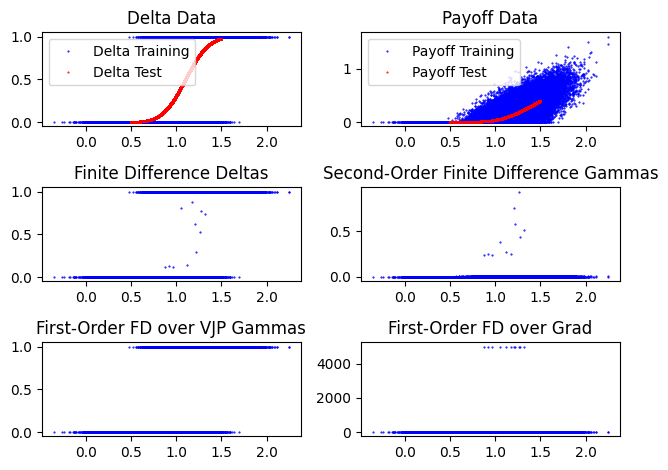

In [ ]:

def plot_payoff_data(axs, x_train, y_train, x_test, y_test):
    axs.set_title("Payoff Data")
    axs.plot(x_train, y_train, 'b.', label='Payoff Training', markersize=1)
    axs.plot(x_test, y_test, 'r.', label='Payoff Test', markersize=1)
    axs.legend()

def plot_delta_data(axs, x_train, x_test, dydx_train, dydx_test):
    axs.set_title("Delta Data")
    axs.plot(x_train, dydx_train, 'b.', label='Delta Training', markersize=1)
    axs.plot(x_test, dydx_test, 'r.', label='Delta Test', markersize=1)
    axs.legend()

fig, axs = plt.subplots(3, 2)

Xs = X

plot_payoff_data(axs[0, 1], Xs, Y[:,0], baskets[:, 0], prices[:,0])
plot_delta_data(axs[0, 0], Xs, baskets[:, 0], Z[:,0], deltas[:,0])

axs[1, 0].set_title("Finite Difference Deltas")
axs[1, 0].plot(Xs, Z_fd, 'b.', label='FD', markersize=1)
axs[1, 1].set_title("Second-Order Finite Difference Gammas")
axs[1, 1].plot(Xs, W_fd_of_fd, 'b.', label='FD', markersize=1)
axs[2, 0].set_title("First-Order FD over VJP Gammas")
axs[2, 0].plot(Xs, W_fd_of_vjp, "b.", label='FD', markersize=1)
axs[2, 1].set_title("First-Order FD over Grad")
axs[2, 1].plot(Xs, W_fd_of_grad, "b.", label='FD', markersize=1)

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()


In [ ]:
bachelier_params = BachelierParams(n_dim=7)
training_set = trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, fd, fdd, jac_fd, fdd_over_grad = astuple(training_set)
spots, baskets, prices, deltas, vegas = testSet(bachelier_params, training_set, n_samples=N_TEST_SAMPLES)
payoff = partial(payoff_fn, a=weights, K=bachelier_params.K)
D_payoff = vmap(grad(payoff))

W_fd_of_fd vs W_fd_of_vjp 0.010045099072158337
Example values: 0.0, 0.0
MSE(Z_grad, Z_analytic) = 0.0
MSE(Z_vjp, Z_analytic) = 0.0
MSE(Y_vjp, Y) = 0.0
Close(Y_vjp, Y) ? True
Close(Z_vjp, Z) ? True
Close(Z_grad, Z) ? True


In [ ]:
print(X.shape)
print(baskets.shape)
print(deltas.shape)
print(Y.shape)

(8192, 7)
(4096, 1)
(4096, 7)
(8192, 1)


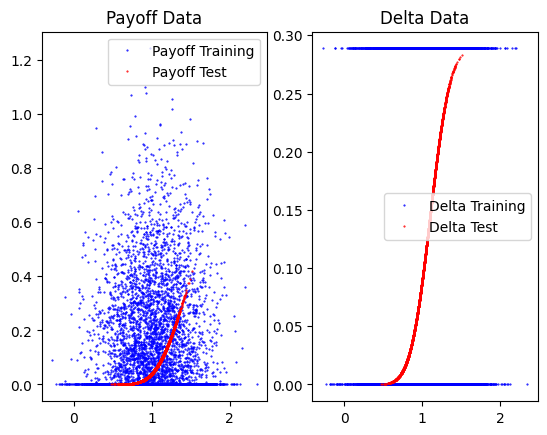

In [ ]:
vis_dim = 0
fig, axs = plt.subplots(1, 2)

plot_payoff_data(axs[0], X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(axs[1], X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

plt.show()

## Train Standard ML

In [ ]:
@jit
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(X)
y_train, y_train_mean, y_train_std = normalize(Y)
dydx_train, dydx_train_mean, dydx_train_std = normalize(Z)

In [ ]:
x_train = X
y_train = Y
dydx_train = Z

In [ ]:
# Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 10
seed = 42

key = jax.random.PRNGKey(seed)

In [ ]:
def x_normalizer(x):
    return (x - x_train_mean) / x_train_std

def y_denormalizer(x):
    return x * y_train_std + y_train_mean

class MLP_Normalized(eqx.Module):
    layers: list

    def __init__(self, key):
        key, subkey = jax.random.split(key)
        self.layers = [x_normalizer, 
                       eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu), 
                       y_denormalizer]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [ ]:
key, subkey = jax.random.split(key)
# model = eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu)
model = MLP_Normalized(key)

In [ ]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  # print(out, in_)
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model


key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

In [ ]:
def mean_squared_error(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.mean((y - pred_y) ** 2)

In [ ]:
class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())

In [ ]:
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"]) -> Float:
    pred_y = vmap(MakeScalar(model))(x)
    chex.assert_type([pred_y], float)
    pred_y = pred_y[:, jnp.newaxis]
    result = mean_squared_error(y, pred_y)
    chex.assert_type([result], float)
    return result

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [ ]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for step, (batch_x, batch_y, batch_dydx) in enumerate(generator_train_ds):
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y)

            if (step % 100 == 0):
                test_loss = loss_fn(model, x_test, y_test)
                # test_loss = 0
                print('Finished epoch {:3d}'.format(epoch), 
                      ' | Train Loss: {:.5f}'.format(train_loss),
                      ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [ ]:
print(vmap(model)(x_train))

print(vmap(MakeScalar(model))(x_train))

[[0.1479365 ]
 [0.15464672]
 [0.13045275]
 ...
 [0.09545115]
 [0.27649486]
 [0.09331221]]
[0.1479365  0.15464672 0.13045275 ... 0.09545115 0.27649486 0.09331221]


In [ ]:
optim = optax.adam(learning_rate)
# model = MakeScalar(model)
model = train(model, x_train, y_train, optim, n_epochs=10)

Finished epoch   0  | Train Loss: 0.03551  | Test Loss: 0.00729
Finished epoch   1  | Train Loss: 0.01470  | Test Loss: 0.00038
Finished epoch   2  | Train Loss: 0.01453  | Test Loss: 0.00016
Finished epoch   3  | Train Loss: 0.01449  | Test Loss: 0.00010
Finished epoch   4  | Train Loss: 0.01449  | Test Loss: 0.00009
Finished epoch   5  | Train Loss: 0.01449  | Test Loss: 0.00008
Finished epoch   6  | Train Loss: 0.01449  | Test Loss: 0.00008
Finished epoch   7  | Train Loss: 0.01449  | Test Loss: 0.00007
Finished epoch   8  | Train Loss: 0.01448  | Test Loss: 0.00006
Finished epoch   9  | Train Loss: 0.01448  | Test Loss: 0.00006


## Plot results

(4096, 1)
RMSE: 0.008196093142032623


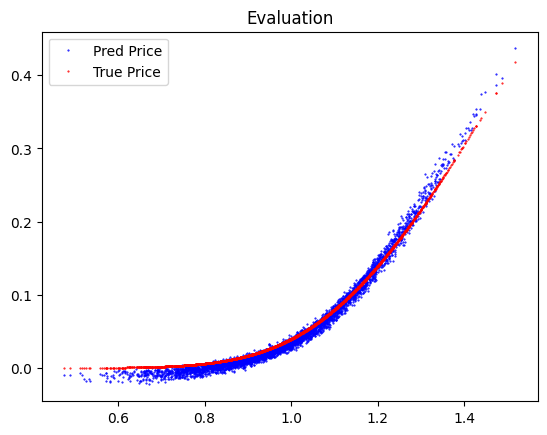

In [ ]:
# scaled input
# x = (x_test - x_train_mean) / x_train_std
x = x_test

pred_y = vmap(model)(x)

# unscale predictions
# pred_y = pred_y * y_train_std + y_train_mean
print(pred_y.shape)
# evaluate
def eval_rmse(y_true: Array, y_pred: Array) -> Float:
    return jnp.sqrt(mean_squared_error(y_true, y_pred))

print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()

RMSE: 0.008196093142032623


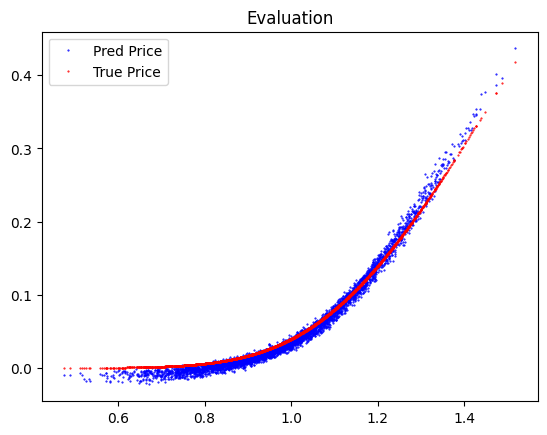

RMSE 0.011428787373006344


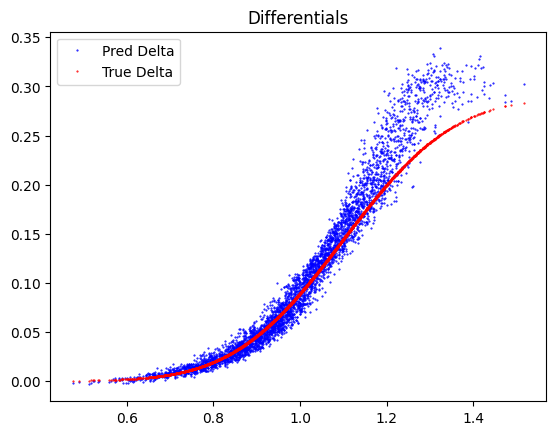

In [ ]:
pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x_test)

pred_y = pred_y[:, jnp.newaxis]
print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()


deltas_rmse = eval_rmse(dydx_test, pred_dydx)
print(f"RMSE {deltas_rmse}")

plt.title("Differentials")
dydx_idx = 0
plt.plot(baskets, pred_dydx[:, dydx_idx], 'b.', markersize=1)
plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
plt.show()

# Differential ML

## Data generation

In [ ]:
def diff_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"]) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # alpha = 0.5
    # beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)

    y_pred = y_pred[..., jnp.newaxis]
    dydx_pred = dydx_pred
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    loss = alpha * jnp.mean((y_pred - y)**2) + beta * jnp.mean((dydx_pred - dydx)**2)
    return loss

In [ ]:
def optimal_step(x: Float):
    h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
    return h * jnp.fabs(x)

In [ ]:
seed = SEED
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
model = MLP_Normalized(key)

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

## Train

In [ ]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for step, (batch_x, batch_y, batch_dydx) in enumerate(generator_train_ds):
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

            if (step % 100 == 0):
                test_loss = diff_loss_fn(model, x_test, y_test, dydx_test)
                print('Finished epoch {:3d}'.format(epoch), 
                      ' | Train Loss: {:.5f}'.format(train_loss),
                      ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [ ]:
optim = optax.adam(learning_rate)
model = train(model, x_train, y_train, optim, n_epochs=10)

Finished epoch   0  | Train Loss: 0.01339  | Test Loss: 0.00319
Finished epoch   1  | Train Loss: 0.00475  | Test Loss: 0.00012
Finished epoch   2  | Train Loss: 0.00467  | Test Loss: 0.00010
Finished epoch   3  | Train Loss: 0.00464  | Test Loss: 0.00009
Finished epoch   4  | Train Loss: 0.00462  | Test Loss: 0.00009
Finished epoch   5  | Train Loss: 0.00461  | Test Loss: 0.00008
Finished epoch   6  | Train Loss: 0.00460  | Test Loss: 0.00008
Finished epoch   7  | Train Loss: 0.00458  | Test Loss: 0.00007
Finished epoch   8  | Train Loss: 0.00457  | Test Loss: 0.00006
Finished epoch   9  | Train Loss: 0.00456  | Test Loss: 0.00005


## Plot results

(4096, 1)
RMSE: 0.00648899981752038


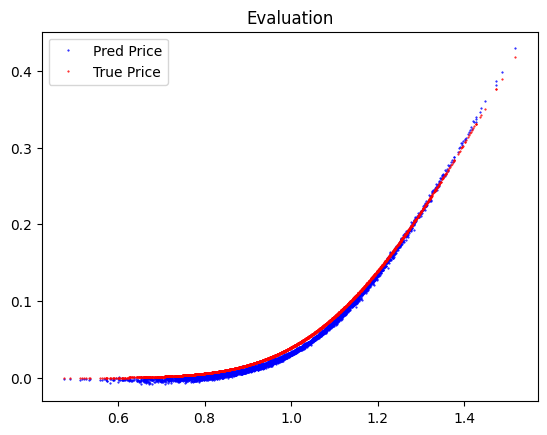

In [ ]:
x = x_test

pred_y = vmap(model)(x)

# unscale predictions
# pred_y = pred_y * y_train_std + y_train_mean
print(pred_y.shape)
# evaluate
def eval_rmse(y_true: Array, y_pred: Array) -> Float:
    return jnp.sqrt(mean_squared_error(y_true, y_pred))

print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()

RMSE: 0.00648899981752038


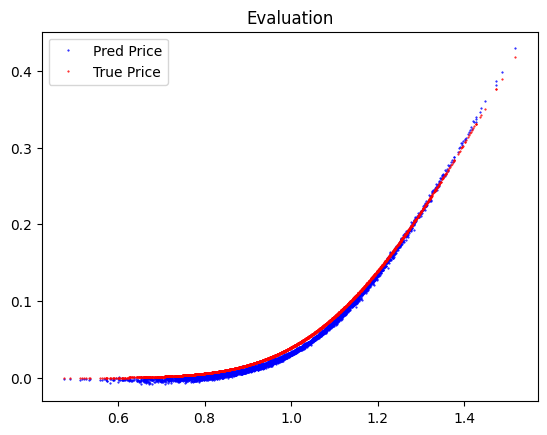

RMSE 0.004759593866765499


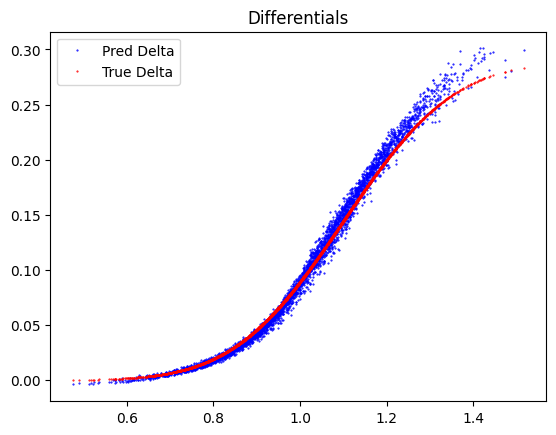

In [ ]:
pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x_test)

pred_y = pred_y[:, jnp.newaxis]
print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()


deltas_rmse = eval_rmse(dydx_test, pred_dydx)
print(f"RMSE {deltas_rmse}")

plt.title("Differentials")
dydx_idx = 0
plt.plot(baskets, pred_dydx[:, dydx_idx], 'b.', markersize=1)
plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
plt.show()

# Differential ML with PCA

## Data generation

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #.cache() #.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE) #.prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [ ]:
import numpy as np

In [ ]:
from enum import Enum

class dydx_type(Enum):
    Default = 1
    MeanAdjusted = 2
    PCA = 3
    PCA_Reduced = 4


def plot_singular_values(S):
    plt.title("Singular Values of Gradient")
    plt.plot(S, 'r', markersize=0)
    plt.show()


def plot_dydx_pred(x, dydx_pred, title):
   
    if title == dydx_type.Default.value:
        plt.title("Predicted Gradients of all Dimensions")
    elif title == dydx_type.MeanAdjusted.value: 
        plt.title("Predicted Gradients of all Dimensions | Mean Adjusted")
    elif title == dydx_type.PCA.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reconstruction")
    elif title == dydx_type.PCA_Reduced.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reduced")
    else:  
        plt.title("Predicted Gradients of all Dimensions")

    for i in range(dydx_pred.shape[1]):
        plt.plot(x[:, i], dydx_pred[:, i], '.', markersize=1)
    plt.show()


def plot_dydx_pred_individual_dims(x, dydx, dydx_pred, dydx_pred_pca, principle_components, pc_scaled):

    for i in range(x.shape[1]):

        plt.title(f"Differentials Dimension {i}")
        plt.plot(x[:, i], dydx[:, i], 'b.', markersize=1)
        plt.plot(x[:, i], dydx_pred[:, i], 'r.', markersize=1)
        plt.show()

        # variance within the dimesions:
        plt.title(f"Variance of Dim {i} (y-axis) w.r.t Dim 0 (x-axis))")
        plt.plot(dydx_pred_pca[:, 0], dydx_pred_pca[:, i], 'b.', markersize=1)


        colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']
        for j, _ in enumerate(principle_components):
            plt.plot(np.array([0, 0 + pc_scaled[j, 0]]),
                    np.array([0,  0 + pc_scaled[j, i]]), '-',  color=colors[j], linewidth=5, label=f"PC{j}")

        plt.legend()
        plt.show()


# def plot_ddyddx(x, ddyddx):
#   plt.title("Gammas ")
#   dydx_idx = 0
#   for i in range(x_test.shape[1]):
#     for j in range(x_test.shape[1]):
#       plt.plot(baskets, pred_ddyddx[:, i, j], '.', markersize=1, label=f"Gamma {i},{j}")
#   plt.legend(loc='upper left')
#   plt.show()


def plot_ddyddx_pred(x, ddyddx):
  colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']
  for i in range(x.shape[1]):
    plt.title(f"2nd-Order Differential Predictions {i}")

    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j], label=f"ddyddx {i},{j}")
    plt.show()


def plot_ddyddx_pred_hvp(x, ddyddx):
  colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']
  plt.title(f"2nd-Order Differential HVP Predictions")
  for i in range(x.shape[1]):
    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j], label=f"ddyddx {i},{j}")
  plt.show()

def plot_ddyddx_fd(x, ddyddx):
  colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']
  plt.title(f"2nd-Order Finite-Difference Predictions")
  for i in range(x.shape[1]):
    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j], label=f"ddyddx {i},{j}")
  plt.show()

def plot_ddyddx_fd_of_grad(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over Grad Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()

def plot_ddyddx_fd_of_grad_full(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over Grad Full Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()

def plot_ddyddx_fd_of_fd(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over FD Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()


def plot_ddyddx_pred_all(x, selected_hvp, hessian_data, hessian, fd_of_grad_full):
  colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']
  titles = ['pc @ hvp', 'hessian data', 'hessian model', 'fd_of_grad']

  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, ddyddx in enumerate([selected_hvp, hessian_data, hessian, fd_of_grad_full]):
    for i in range(x.shape[1]):
      for j in range(ddyddx.shape[1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(titles[k])
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()
  



def plot_batch(x, y, y_pred):
    plt.title("Data Batch Normalized")
    plt.plot(x, y, 'b.', markersize=1)
    plt.plot(x, y_pred, 'r.', markersize=1)
    plt.show()


def diff_pca_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"], debug: bool = True) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # alpha = 0.5
    # beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)

    # for now we instantiate the full hessian matrix
    hess = jax.hessian(MakeScalar(model))
    hessian = eqx.filter_vmap(hess)(x)
    # jax.debug.print("Hessian: {H}", H=hessian.shape)

    y_pred = y_pred[..., jnp.newaxis]
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)

    dydx_pred_means = jnp.mean(dydx_pred, axis=0)
    # print("dydx_pred_means.shape:", dydx_pred_means.shape)
    # print("dydx_pred_means: ", dydx_pred_means)

    dydx_pred_mean_adjusted = dydx_pred - jnp.tile(dydx_pred_means, (dydx_pred.shape[0], 1))

    U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)

    # the principle components give use the directions for the hesse vectors
    principle_components = jnp.diag(S) @ VT

    # we need the vjp_fun from eqx.filter_vjp 
    # then we can *hopefully* use eqx.filter_vjp(vjp_fun, principle_components) 
    # to get to selected hvp results. Those can then be used as part of the loss  

    partial_vjp = partial(eqx.filter_vjp, MakeScalar(model))
    y_pred_vjp, vjp_fun = vmap(partial_vjp)(x)

    # jax.debug.print("function is: {fn}", fn=vjp_fun)
    # test_values = vmap(vjp_fun)(jnp.ones_like(y_pred_vjp))
    # jax.debug.print("test values = {tv}", tv=test_values)

    y_pred_vjp = y_pred_vjp[..., jnp.newaxis]

    # jax.debug.print("y_pred={y}", y=y_pred)
    # jax.debug.print("y_pred_vjp={y}", y=y_pred_vjp)
    # jax.debug.print("MSE(y_pred, y_pred_vjp) = {res}", res=mean_squared_error(y_pred, y_pred_vjp))
    # chex.assert_trees_all_close(y_pred, y_pred_vjp)


    # jax.debug.print("shape must be: {shape}", shape=y_pred_vjp.shape)
    # jax.debug.print("but we have: {shape}", shape=x.shape)
    # dydx_pred_vjp, hvp_fun = vmap(partial(eqx.filter_vjp, vjp_fun))(x)


    # basis = jnp.eye(y_pred_vjp.size, dtype=y.dtype)
    # jac = vmap(vjp_fun)(basis)[0] 

    # ---

    # jax.debug.print("Hessian shape {H}", H=hessian.shape)
    # jax.debug.print("Principle components shape: {PC}", PC=principle_components.shape)

    selected_hvp = principle_components @ hessian
    jax.debug.print("Selcted HVP shape: {hvp}", hvp=selected_hvp.shape)
    # jax.debug.print("Selcted HVP: {hvp}", hvp=selected_hvp)

    if debug:

      # compute second order central finite differences of model
      h = 1e-4
      fdd_x = x
      grad_model = vmap(eqx.filter_grad(MakeScalar(model)))

      # here we directly perturbe all values of fdd_x. I think we need to do
      # this on a per element basis
      xph = fdd_x + h
      xmh = fdd_x - h
      fdd_xph = grad_model(xph)
      fdd_xmh = grad_model(xmh)
      fd_of_grad = (fdd_xph - fdd_xmh) / (2 * h)

      fd_of_fd_xph = vmap(model)(xph)
      fd_of_fd_xmh = vmap(model)(xmh)
      fd_of_fd = (fd_of_fd_xph - 2 * y_pred + fd_of_fd_xmh) / (h * h)

      def fd_row(i):
          xph = fdd_x.at[:, i].set(fdd_x[:, i] + h)
          xmh = fdd_x.at[:, i].set(fdd_x[:, i] - h)
  
          fdd_xph = grad_model(xph)
          fdd_xmh = grad_model(xmh)
          fdd_i = (fdd_xph - fdd_xmh) / (2 * h) 
          return fdd_i

      fd_of_grad_full = jnp.transpose(jnp.array([fd_row(i) for i in range(x.shape[-1])]), (1, 0, 2))

      hessian_data = jnp.zeros_like(hessian)
      jax.debug.print("FD_of_grad shape: {fd}", fd=fd_of_grad.shape)
      jax.debug.print("FD_of_grad_full shape: {fd}", fd=fd_of_grad_full.shape)
      jax.debug.print("FD_of_FD shape: {fd}", fd=fd_of_fd.shape)
      jax.debug.print("hessian shape: {fd}", fd=hessian.shape)

      pc_scaled = principle_components / jnp.sqrt(x.shape[0])
      dydx_pred_pca = U @ principle_components
      k_dims = 1
      dydx_pred_reduced = U[:, :k_dims] @ principle_components[:k_dims, :]

      pca_reconstruction_err = mean_squared_error(dydx_pred_mean_adjusted, dydx_pred_pca)
      jax.debug.print("pca reconstruction_err: {err}", err=pca_reconstruction_err)

      reduced_reconstruction_err = mean_squared_error(dydx_pred_mean_adjusted, dydx_pred_reduced)
      jax.debug.print("reduced ({dim} dims) reconstruction_err: {err}", dim=k_dims, err=reduced_reconstruction_err)

      # TODO: Still need to figure out how to use chex in the context of a jitted eqx function
      # chex.assert_trees_all_close(dydx_pred_pca, dydx_pred_mean_adjusted)

      # print("sanity checks")
      I = jnp.eye(VT.shape[0], U.shape[1])
      UU = U.T @ U
      # print("U.T @ U = ", UU)
      # print("shapes: I: ", I.shape)
      # print("shapes: UU: ", UU.shape)

      # chex.assert_trees_all_close(UU, I)

      chex.assert_rank(UU, 2)
      chex.assert_rank(VT, 2)

      chex.assert_shape(UU, I.shape)
      chex.assert_shape(VT, I.shape)
      # chex.assert_shape(UU.shape, I.shape)
      # assert(jnp.allclose(UU, I, atol=1e-06))
      VV = VT @ VT.T
      # print("V.T @ V = ", VV)
      chex.assert_shape(VV, I.shape)

      # jax.debug.print("VT: {VT}", VT=VT)
      # jax.debug.print("Principle Components: {pc}", pc=pc_scaled)

      # result_shape = jax.ShapeDtypeStruct(S.shape, S.dtype)
      # jax.pure_callback(plot_singular_values, result_shape, S)


      # jax.debug.callback(plot_singular_values, S)

      # jax.debug.callback(plot_dydx_pred, x, dydx_pred, dydx_type.Default.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.MeanAdjusted.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA_Reduced.value)
      # jax.debug.callback(plot_dydx_pred_individual_dims, x, dydx, dydx_pred, dydx_pred_pca, principle_components, pc_scaled)
      # jax.debug.callback(plot_ddyddx_pred, x, selected_hvp)
      # jax.debug.callback(plot_ddyddx_pred_hvp, x, selected_hvp)
      jax.debug.callback(plot_ddyddx_pred_all, x, selected_hvp, hessian_data, hessian, fd_of_grad_full)
      # jax.debug.callback(plot_ddyddx_fd, x, fdd)
      # jax.debug.callback(plot_ddyddx_fd_of_grad, x, fd_of_grad)
      # jax.debug.callback(plot_ddyddx_fd_of_grad_full, x, fd_of_grad_full)
      # jax.debug.callback(plot_ddyddx_fd_of_fd, x, fd_of_fd)

      # jax.debug.print("Close(Hessian, FD_of_Grad) ? {res}", res=jnp.allclose(hessian, fd_of_grad_full))
      jax.debug.print("Close(Hessian, FD_of_Grad) ? {res}", res=mean_squared_error(hessian, fd_of_grad_full))

      # jax.debug.callback(plot_batch, x, y, y_pred)


      # chex.assert_trees_all_close(UU, I)
      # jax.experimental.checkify.check(jnp.allclose(UU, I, atol=1e-6), "Identity not fulfilled")

      # identities(UU, I)
      # print("S = ", S)
      # print("Pc.shape: ", pc_scaled.shape)
      # print("Principle components")

      # plt.title("Singular Values of Gradient")
      # plt.plot(S, 'r', markersize=0)
      # plt.show()

    loss = alpha * jnp.mean((y_pred - y)**2) + beta * jnp.mean((dydx_pred - dydx)**2)
    return loss


## Train

In [ ]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_pca_loss_fn)(model, x, y, dydx, debug=True)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for step, (batch_x, batch_y, batch_dydx) in enumerate(generator_train_ds):
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

            if (step % 100 == 0):
                test_loss = diff_pca_loss_fn(model, x_test, y_test, dydx_test, debug=False)
                print('Finished epoch {:3d}'.format(epoch), 
                    ' | Train Loss: {:.5f}'.format(train_loss),
                    ' | Test Loss: {:.5f}'.format(test_loss))

    return model

Selcted HVP shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_grad shape: (array(256, dtype=int32), array(7, dtype=int32))
FD_of_grad_full shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_FD shape: (array(256, dtype=int32), array(1, dtype=int32))
hessian shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
pca reconstruction_err: 4.569126004572231e-16
reduced (1 dims) reconstruction_err: 0.0003714369086083025


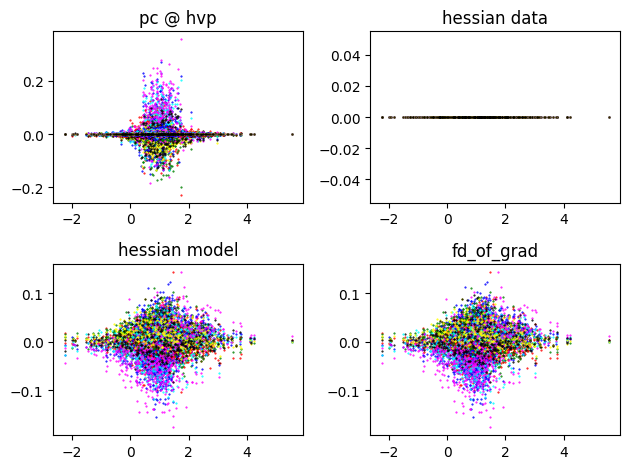

Close(Hessian, FD_of_Grad) ? 5.137173797464811e-09
Selcted HVP shape: (4096, 7, 7)
Finished epoch   0  | Train Loss: 0.02536  | Test Loss: 0.00713
Selcted HVP shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_grad shape: (array(256, dtype=int32), array(7, dtype=int32))
FD_of_grad_full shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_FD shape: (array(256, dtype=int32), array(1, dtype=int32))
hessian shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
pca reconstruction_err: 1.7729328675296526e-16
reduced (1 dims) reconstruction_err: 0.0002966676256619394


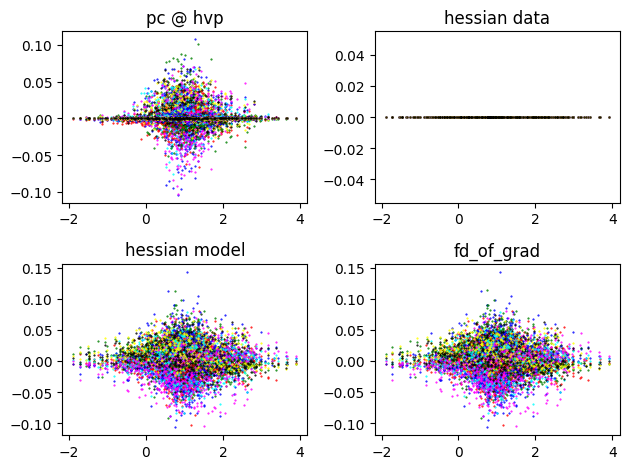

Close(Hessian, FD_of_Grad) ? 5.464214414274693e-09
Selcted HVP shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_grad shape: (array(256, dtype=int32), array(7, dtype=int32))
FD_of_grad_full shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_FD shape: (array(256, dtype=int32), array(1, dtype=int32))
hessian shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
pca reconstruction_err: 1.3074845572442703e-16
reduced (1 dims) reconstruction_err: 0.00015291535237338394


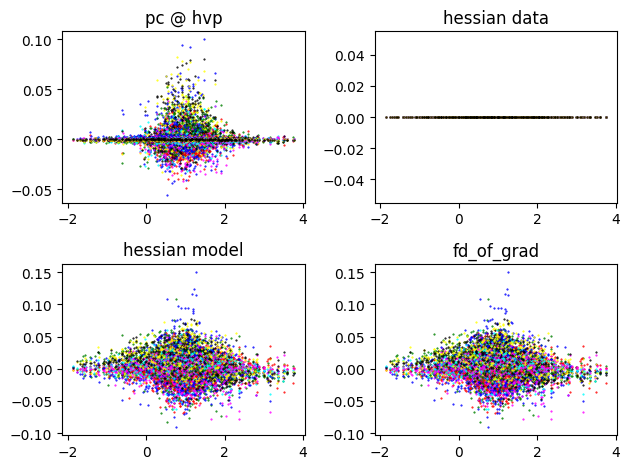

Close(Hessian, FD_of_Grad) ? 3.450824070938552e-09
Selcted HVP shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_grad shape: (array(256, dtype=int32), array(7, dtype=int32))
FD_of_grad_full shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_FD shape: (array(256, dtype=int32), array(1, dtype=int32))
hessian shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
pca reconstruction_err: 1.0173404356539042e-16
reduced (1 dims) reconstruction_err: 0.0001715114776743576


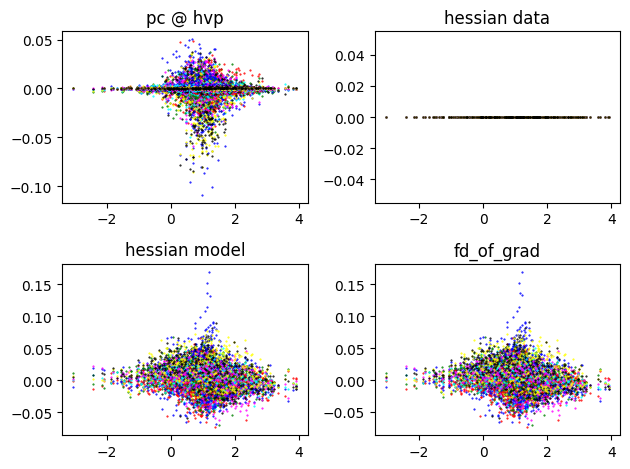

Close(Hessian, FD_of_Grad) ? 1.1216022777205126e-08
Selcted HVP shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_grad shape: (array(256, dtype=int32), array(7, dtype=int32))
FD_of_grad_full shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_FD shape: (array(256, dtype=int32), array(1, dtype=int32))
hessian shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
pca reconstruction_err: 8.716931203735272e-17
reduced (1 dims) reconstruction_err: 0.0002322309446753934


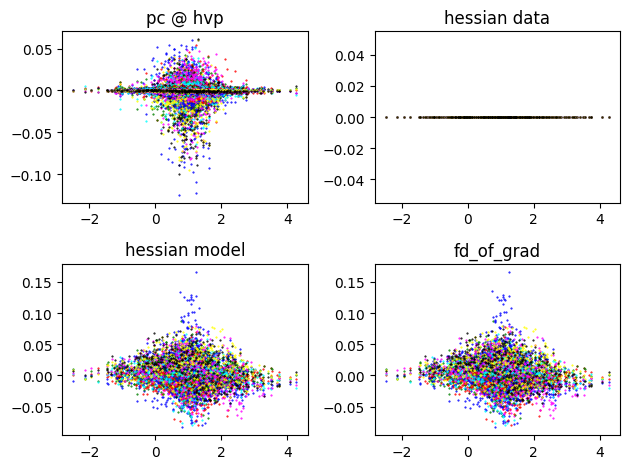

Close(Hessian, FD_of_Grad) ? 3.6101648337449888e-09
Selcted HVP shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_grad shape: (array(256, dtype=int32), array(7, dtype=int32))
FD_of_grad_full shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_FD shape: (array(256, dtype=int32), array(1, dtype=int32))
hessian shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
pca reconstruction_err: 6.180146274302958e-17
reduced (1 dims) reconstruction_err: 0.00024978042347356677


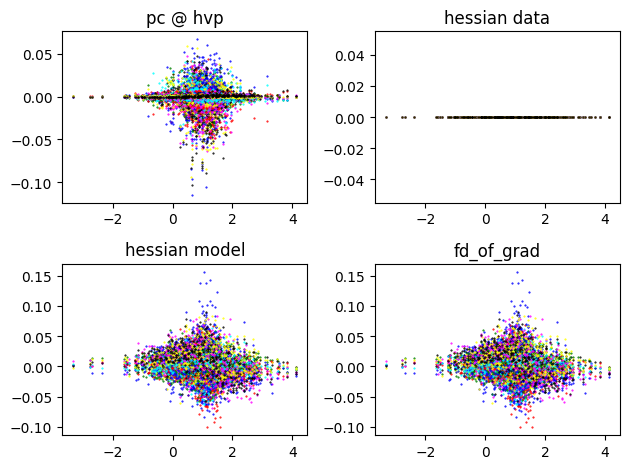

Close(Hessian, FD_of_Grad) ? 2.8235364268880403e-08
Selcted HVP shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_grad shape: (array(256, dtype=int32), array(7, dtype=int32))
FD_of_grad_full shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
FD_of_FD shape: (array(256, dtype=int32), array(1, dtype=int32))
hessian shape: (array(256, dtype=int32), array(7, dtype=int32), array(7, dtype=int32))
pca reconstruction_err: 9.070580032359253e-17
reduced (1 dims) reconstruction_err: 0.00028995738830417395


KeyboardInterrupt: ignored

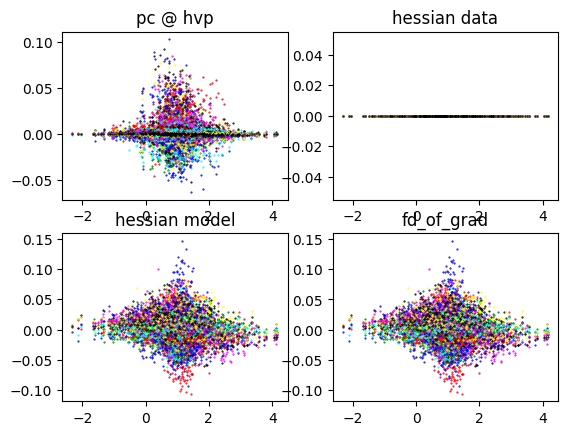

In [ ]:
key, subkey = jax.random.split(key)
model = MLP_Normalized(key)

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

optim = optax.adam(learning_rate)
model = train(model, x_train, y_train, optim, n_epochs=10)

## Experiment

In [ ]:
def f(x):
  return x**2

xs = jnp.array([[3., 2., 1.]])
dys = jnp.array([[3., 2., 1.], 
                 [3., 2., 1.], 
                 [3., 2., 1.]])

pcs = jnp.array([[3., 2., 1.], 
                 [1., 1., 1.], 
                 [1., 2., 3.]])

print(xs.shape)
print(dys.shape)

print(xs @ dys)

print(pcs @ dys)
print(dys @ pcs)
# print(jnp.vdot(xs, dys))

hessian = jnp.tile(dys, (256, 1, 1))
print(hessian.shape)
print(pcs.shape)

# broadcasts the pcs accordingly
hvp = pcs @ hessian
print(hvp.shape)


(1, 3)
(3, 3)
[[18. 12.  6.]]
[[18. 12.  6.]
 [ 9.  6.  3.]
 [18. 12.  6.]]
[[12. 10.  8.]
 [12. 10.  8.]
 [12. 10.  8.]]
(256, 3, 3)
(3, 3)
(256, 3, 3)


In [ ]:
def f(x):
  return x**2

xs = jnp.array([3.0, 2.0, 1.0])

dys = vmap(grad(f))(xs)
print(dys)
print(dys.shape)
# only now we know the vectors
# vs = 

# jnp.vdot(dys, jnp.ones_like(dys))

vmap(jax.hessian(f))(xs)
jax.hessian(f)(xs)

[6. 4. 2.]
(3,)


Array([[[2., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 2., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 2.]]], dtype=float32)

In [ ]:
def f(x):
  return x**2

xs = jnp.array([3.0, 2.0, 1.0])

y, vjp_fn = jax.vjp(f, xs)
print(y)

dy = vjp_fn(jnp.ones_like(y))
print(dy)

dy_vjp, vjpvjp_fn = jax.vjp(vjp_fn, jnp.ones_like(y))
print(dy_vjp)

# ddy = vjpvjp_fn(jnp.ones_like(dy_vjp))
# ddy = vjpvjp_fn((jnp.ones_like(dy_vjp[0]),))
# print(ddy)

# hvp(f, xs, xs)

hess = jax.hessian(f)
print(vmap(hess)(xs))


[9. 4. 1.]
(Array([6., 4., 2.], dtype=float32),)
(Array([6., 4., 2.], dtype=float32),)
[2. 2. 2.]


In [ ]:
# experiment with using finite differences over vjp

def f(x):
  return 2 * x**3

xs = jnp.array([1.0, 2.0])
y, vjp_fn = jax.vjp(f, xs)
print(y)

cotangent = jnp.ones_like(y)
print(cotangent)
dy, vjpvjp_fn = jax.vjp(vjp_fn, cotangent)
print(dy)

# using ad
ddy = vjpvjp_fn((jnp.ones_like(y), ))
print(ddy)

# now using fd, NOTE: I don't actually need vjpvjp here
h = 1e-3

fd_xph = f(xs + jnp.array([h, h]))
fd_xmh = f(xs - jnp.array([h, h]))
fd = (fd_xph - fd_xmh) / (2 * h)
print("FD of f(x)")
print(fd)


fdd_xph, = vjp_fn(cotangent + jnp.array([h, h]))
fdd_xmh, = vjp_fn(cotangent - jnp.array([h, h]))

print(fdd_xph)
print(fdd_xmh)
fdd = (fdd_xph - fdd_xmh) / (2 * h)

print("FD over vjp of f(x)")
print(fdd)

grad_f = grad(f)

fdd_xph = vmap(grad_f)(xs + h)
fdd_xmh = vmap(grad_f)(xs - h)
fdd = (fdd_xph - fdd_xmh) / (2 * h)
print("FD over grad of f(x)")
print(fdd)

jax.hessian(f)(xs)

[ 2. 16.]
[1. 1.]
(Array([ 6., 24.], dtype=float32),)
(Array([ 6., 24.], dtype=float32),)
FD of f(x)
[ 6.0000415 23.99969  ]
[ 6.0060005 24.024002 ]
[ 5.994 23.976]
FD over vjp of f(x)
[ 6.00028 24.00112]
FD over grad of f(x)
[12.000083 23.999212]


Array([[[12.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0., 24.]]], dtype=float32)

In [ ]:
def f(x):
    return x**2

partial_vjp = partial(jax.vjp, f)

# xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = partial_vjp(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])

print(vjp_fn)

dy = vjp_fn(jnp.ones_like(y))
print(dy)

[3. 2. 1.]
[9. 4. 1.]
()
9.0
Partial(_HashableCallableShim(functools.partial(<function _vjp_pullback_wrapper at 0x7f181ffdd1b0>, 'f', [dtype('float32')], [(3,)], (PyTreeDef(*), PyTreeDef((*,))))), Partial(_HashableCallableShim(functools.partial(<function vjp.<locals>.unbound_vjp at 0x7f1781eb3d00>, [(ShapedArray(float32[3]), None)], { lambda a:f32[3]; b:f32[3]. let c:f32[3] = mul b a in (c,) })), (Array([6., 4., 2.], dtype=float32),)))
(Array([6., 4., 2.], dtype=float32),)


In [ ]:

def inner_fn(x):
    return x ** 3

def outer_fn(x):
    # def inner(x, y):
        # return inner_fn(x, y)
    
    _, vjp_inner = jax.vjp(inner_fn, x)
    cotangent = jnp.ones_like(x)
    grad_inner_x, = vjp_inner(x)
    return grad_inner_x

# Example usage
# x = jnp.array([2.0, 1.0])
x = jnp.array(1.0)
y = jnp.array(3.0)

grad_inner_x, vjp_outer = jax.vjp(outer_fn, x)
grad_outer_x = vjp_outer(1.0)

print(f"Gradient of inner_fn with respect to x: {grad_inner_x}")
print(f"Gradient of outer_fn with respect to x: {grad_outer_x}")
# print(f"Gradient of outer_fn with respect to y: {grad_outer_y}")

Gradient of inner_fn with respect to x: 3.0
Gradient of outer_fn with respect to x: (Array(9., dtype=float32, weak_type=True),)


In [ ]:
def f(x):
    return x**2

partial_vjp = partial(jax.vjp, f)

xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
# xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = eqx.filter_vmap(partial_vjp)(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])

print(vjp_fn)


# this is an internal problem of the generated vjp_fn since 
# it probably gets confused with the vmap
# print(vjp_fn(jnp.ones_like(y[0])))

# but the below also doesn't work
# print(vjp_fn(jnp.ones_like(y)))

# print(vmap(vjp_fn)(jnp.ones(shape=(3,3))))


[[3. 2. 1.]
 [6. 5. 4.]
 [9. 8. 7.]]
[[ 9.  4.  1.]
 [36. 25. 16.]
 [81. 64. 49.]]
(3,)
[9. 4. 1.]
Partial(_HashableCallableShim(functools.partial(<function _vjp_pullback_wrapper at 0x7f181ffdd1b0>, 'f', [dtype('float32')], [(3,)], (PyTreeDef(*), PyTreeDef((*,))))), Partial(_HashableCallableShim(functools.partial(<function vjp.<locals>.unbound_vjp at 0x7f178ad72e60>, [(ShapedArray(float32[3]), None)], { lambda a:f32[3]; b:f32[3]. let c:f32[3] = mul b a in (c,) })), (Array([[ 6.,  4.,  2.],
       [12., 10.,  8.],
       [18., 16., 14.]], dtype=float32),)))


In [ ]:
def f(x):
    return x**2

# maybe first vmap the vjp?
# partial_vjp = partial(jax.vjp, f)
vmap_vjp = vmap(lambda x: jax.vjp(f, x))

xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
# xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = vmap_vjp(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])


#print(vjp_fn(jnp.ones_like(y)))


[[3. 2. 1.]
 [6. 5. 4.]
 [9. 8. 7.]]
[[ 9.  4.  1.]
 [36. 25. 16.]
 [81. 64. 49.]]
(3,)
[9. 4. 1.]


## Plot results

RMSE: 0.002088847802951932


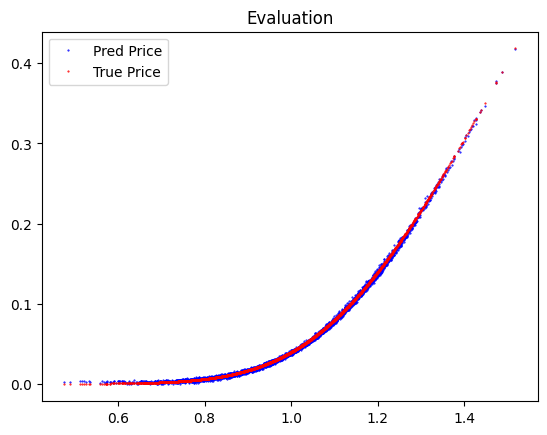

RMSE 0.003052718471735716


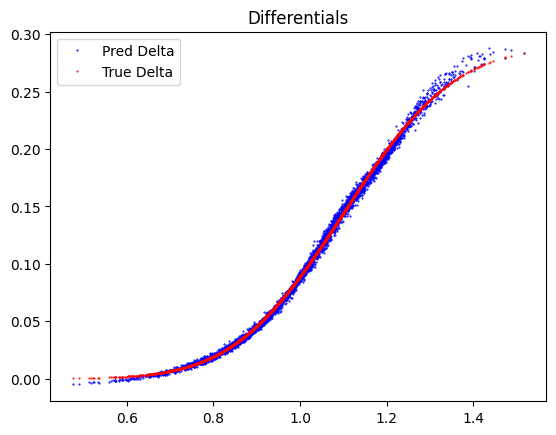

In [ ]:
pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x_test)

pred_y = pred_y[:, jnp.newaxis]
print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()


deltas_rmse = eval_rmse(dydx_test, pred_dydx)
print(f"RMSE {deltas_rmse}")

plt.title("Differentials")
dydx_idx = 0
plt.plot(baskets, pred_dydx[:, dydx_idx], 'b.', markersize=1)
plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
plt.show()